In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from os import listdir
import scipy.io as sio


plt.style.use('rossidata')

In [10]:
data=pd.read_csv('data/dual_megaframe.csv')
data['Time of Death'][data['Time of Death']==0]=np.nan
data['Time of Death'][data['Time of Death']==-1]=64
data=data[~np.isnan(data['Time of Death'])]
data['Fluor2 mean']=data['Fluor2 mean']#-data['Fluor1 mean']*0.05



In [21]:
folder='data/ppi_snaps'
names = listdir(folder)
del snap1
if '.DS_Store' in names:
    names.remove('.DS_Store')

names = [folder + '/' + name for name in names]

for name in names[0:4]:
    mat_contents = sio.loadmat(name)
    df2 = pd.DataFrame(mat_contents['data'], columns=[x[0] for x in mat_contents['def'][0]])


    if 'snap1' in locals():

        snap1=pd.concat([snap1,df2], ignore_index=True)
        #df1 = df1.append(df2, ignore_index=True)
    else:
        snap1 = df2

In [29]:
plt.close('all')
fig,ax=plt.subplots()
ax.scatter(data['Fluor1 mean'],data['Fluor2 mean']-0.04411275273917313*data['Fluor1 mean'])
fig

data['Fluor2 mean']=data['Fluor2 mean']-0.04411275273917313*data['Fluor1 mean']
# plt.close('all')
# fig,ax=plt.subplots()
# ax.scatter(snap1['Fluor1 mean'],snap1['Fluor2 mean'])
# np.mean(snap1['Fluor2 mean']/snap1['Fluor1 mean'])

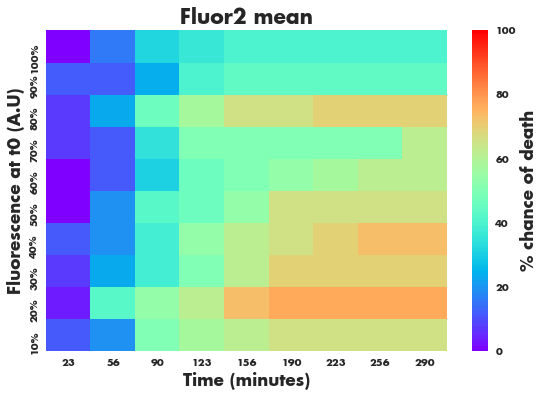

In [30]:
#heatmaps

#dataload
terms=['Fluor1 mean','Fluor2 mean']

for term in terms:
    plt.close('all')
    sliceo=data



    InitialAu=sliceo[term]
    Deathtime=sliceo['Time of Death']

    d = {'InitialAu': InitialAu, 'DeathTime': Deathtime}
    df = pd.DataFrame(data=d)
    df['DeathTime'][df['DeathTime']==-1]=62
    df['DeathTime'][df['DeathTime']==0]=np.nan

    fig,ax=plt.subplots()
    df=df.dropna()
    s={'fluor':df['InitialAu'],'death':5*df['DeathTime']}
    sd=pd.DataFrame(s)
    sd=sd[~np.isnan(sd['death'])]
    sd=sd.sort_values(by='fluor')
    n_splits=10
    rez=np.array_split(sd, n_splits)
    column_num=10
    bins=np.linspace(0,300,column_num)-10
    grid=np.zeros((n_splits,column_num-1))
    labels=np.zeros((n_splits,column_num-1))
    mins=[]
    
    for x in range(n_splits):
        mino,maxo=min(rez[x].fluor),max(rez[x].fluor)
        grid[x,:]=np.cumsum(np.histogram(rez[x].death, bins=bins)[0]/len(rez[x].death))
        labels[x,:]=np.histogram(rez[x].death, bins=bins)[0]
        mins.append(str((x+1)*10)+'%')

    sns.heatmap(np.flipud(grid)*100,yticklabels=np.flipud(mins),xticklabels=[int(u) for u in bins[1:]],cmap="rainbow",vmin=0, vmax=100,cbar_kws={'label': '% chance of death'})
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Fluorescence at t0 (A.U)')
    ax.set_title(term)
    fig.savefig('figures/'+term+'_heatmap.png',dpi=300)
fig

In [31]:
plt.close('all')
fig_animate,ax=plt.subplots()

lines=[]
terms=['Fluor1 mean','Fluor2 mean']
colors=['#e684ae','teal']
ax.set_xlim([800,5500])
ax.set_ylim([350,550])

lines.append(ax.plot([],[],color=colors[0],marker='o',linewidth=0))
average=ax.plot([],[],color='black',marker='o',linewidth=0)


def animate(z):
    donnes=data[data['Time of Death']>=z]


    lines[0][0].set_data(donnes['Fluor1 mean'],donnes['Fluor2 mean'])
    average[0].set_data(np.mean(donnes['Fluor1 mean']),np.mean(donnes['Fluor2 mean']))
    return lines

anim3 = animation.FuncAnimation(fig_animate, animate,frames=61,  blit=False)
plt.tight_layout()
HTML(anim3.to_html5_video())
#anim3.save('scatter_evolved.mp4', writer='ffmpeg',bitrate=1800)

In [ ]:
### animation of distribution
plt.close('all')
fig_animate,ax=plt.subplots(2,1)

lines=[]
terms=['Fluor1 mean','Fluor2 mean']
colors=['#e684ae','teal']
lims=[[700,1500],[450,650]]
ylims=[[0,.01],[0,.03]]
for n,l in enumerate(terms):
    lines.append(ax[n].plot([],[],color=colors[n]))
    ax[n].set_xlim(lims[n])
    ax[n].set_xscale('log')
    ax[n].set_ylim(ylims[n])
xs = np.linspace(450,1500,200)

def animate(z):
    for j,term in enumerate(terms):
        density = gaussian_kde(data[term][data['Time of Death']>=z])
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ax[j].plot(xs,density(xs),color='grey',alpha=0.05)

        lines[j][0].set_data(xs,density(xs))

    return lines

anim3 = animation.FuncAnimation(fig_animate, animate,frames=61,  blit=False)
plt.tight_layout()
anim3.save('evolution.mp4', writer='ffmpeg',bitrate=1800)
#HTML(anim3.to_html5_video())